In [1]:
import h5py
import sys
from scipy import constants as sp
import os
import datetime
from dateutil import parser
from matplotlib import pyplot as plt
from numba import njit, prange

sys.path.append('..')

from solver import solver
from analyzer import analyzer
from integrators import relativistic_boris
from plot import plot_field
from utils import field_line, Re

from fields import *
from distributions import *

In [2]:
# T89 PARAMS
t1 = datetime.datetime(2008, 3, 26, 11, 30)
t0 = datetime.datetime(1970, 1, 1)
ut = (t1-t0).total_seconds()

Ey = 3.54e-3

Vx = -456.3
Vy = -32.3
Vz = 23.2

Kp = round(4.5)

parmod_t89 = Kp

In [3]:
# T96 PARAMS
t1 = datetime.datetime(2008, 3, 26, 11, 30)
t0 = datetime.datetime(1970, 1, 1)
ut = (t1-t0).total_seconds()

Ey = 3.54e-3

Vx = -456.3
Vy = -32.3
Vz = 23.2

Pdyn = 3.93
Dst = 11
ByIMF = -1.36
BzIMF = -7.74

parmod_t96 = np.array([Pdyn, Dst, ByIMF, BzIMF, 0., 0., 0., 0., 0., 0.])

In [4]:
# T01 PARAMS
# HOUR 11
'''
t1 = datetime.datetime(2008, 3, 26, 11)
t0 = datetime.datetime(1970, 1, 1)
ut = (t1-t0).total_seconds()

Ey = 3.54e-3

Vx = -444.0
Vy = 0.0
Vz = 0.0

Pdyn = 3.16
Dst = -3
ByIMF = 0.40
BzIMF = -8.50
G1 = 7.30
G2 = 11.24
'''


# HOUR 12
#'''
t1 = datetime.datetime(2008, 3, 26, 12)
t0 = datetime.datetime(1970, 1, 1)
ut = (t1-t0).total_seconds()

Ey = 3.54e-3

Vx = -442.0
Vy = 0.0
Vz = 0.0

Pdyn = 2.79
Dst = -20
ByIMF = -3.80
BzIMF = -3.70
G1 = 9.42
G2 = 13.07
#'''

parmod_t01 = np.array([Pdyn, Dst, ByIMF, BzIMF, 0., 0., 0., 0., 0., 0.])

In [5]:
# T04 PARAMS

# HOUR 11
#'''
t1 = datetime.datetime(2008, 3, 26, 11)
t0 = datetime.datetime(1970, 1, 1)
ut = (t1-t0).total_seconds()

Ey = 3.54e-3

Vx = -444.0
Vy = 0.0
Vz = 0.0

Pdyn = 3.16
Dst = -3
ByIMF = 0.40
BzIMF = -8.50
W1 = 0.996
W2 = 1.181
W3 = 0.259
W4 = 1.292
W5 = 1.528
W6 = 3.604
#'''

# HOUR 12
'''
t1 = datetime.datetime(2008, 3, 26, 12)
t0 = datetime.datetime(1970, 1, 1)
ut = (t1-t0).total_seconds()

Ey = 3.54e-3

Vx = -444.0
Vy = 0.0
Vz = 0.0

Pdyn = 3.16
Dst = -3
ByIMF = 0.40
BzIMF = -8.50
W1 = 1.175
W2 = 1.316
W3 = 0.318
W4 = 1.509
W5 = 1.583
W6 = 3.246
'''

parmod_t04 = np.array([Pdyn, Dst, ByIMF, BzIMF, 0., 0., 0., 0., 0., 0.])

In [6]:
#e_field = zero_field()
e_field = uniform_field(Ey, np.array([0., 1., 0.]))

#b_field = t89(parmod_t89, t0=ut, sw_v=np.array([Vx, Vy, Vz]))
#b_field = t96(parmod_t96, t0=ut, sw_v=np.array([Vx, Vy, Vz]))
#b_field = t01(parmod_t01, t0=ut, sw_v=np.array([Vx, Vy, Vz]))
b_field = t04(parmod_t04, t0=ut, sw_v=np.array([Vx, Vy, Vz]))

s = solver(e_field, xz_slice(b_field), drop_lost=False)

Load IGRF coefficients ...


In [7]:
s.populate_by_eq_pa(5000,
                    9.5,
                    delta(5e5),
                    uniform(np.radians(0), np.radians(90)),
                    uniform(0, 2 * np.pi)
                   )

100%|██████████| 5000/5000 [00:05<00:00, 876.08it/s]


In [8]:
s.solve(2, 1e-4, 1e-3)

100%|██████████| 5000/5000 [44:37<00:00,  1.87it/s]  


In [9]:
s.save('nithin_event')

nithin_event already exists. Overwrite? (Y/N) Y
Saved file nithin_event.hdf5 containing 653.21 megabytes of information.


In [9]:
a = analyzer('nithin_event')

Loaded file nithin_event.hdf5 containing 956.61 megabytes of information.


In [8]:
plt.semilogy(np.degrees(mus), np.mean(diff[:, 500:1300], axis=1))
plt.grid()
plt.show()

plt.plot(np.degrees(mus), np.degrees(np.mean(tran[:, 500:1300], axis=1)))
plt.grid()
plt.show()

NameError: name 'mus' is not defined

In [2]:
gca_results = gca(a.magnetic_field(), a.position(), a.velocity(), a.mass(), a.charge())

In [6]:
@njit(parallel=True)
def b_along_gca(b_field, gca_results, time):
    num_particles = np.shape(gca_results)[0]
    steps = np.shape(gca_results)[1]

    b_along_gca_v = np.zeros((num_particles, steps, 3))
    
    for i in prange(num_particles):
        for j in prange(steps):
            if (gca_results[i, j] == 0).all():
                continue
                
            b_along_gca_v[i, j, :] = b_field(gca_results[i, j, :], time[j])

    return b_along_gca_v

In [33]:
b_field_89 = t89(parmod_t89, t0=ut, sw_v=np.array([Vx, Vy, Vz]))
b_field_96 = t96(parmod_t96, t0=ut, sw_v=np.array([Vx, Vy, Vz]))
b_field_01 = t01(parmod_t01, t0=ut, sw_v=np.array([Vx, Vy, Vz]))
b_field_04 = t04(parmod_t04, t0=ut, sw_v=np.array([Vx, Vy, Vz]))

In [79]:
rr = field_line(b_field_04, np.array([-10.5 * Re, 0, 0]))

In [83]:
from utils import b_along_path
vec, mag, r_mag = b_along_path(b_field_04, rr)

In [84]:
np.amin(mag)

2.1795959972812312e-09

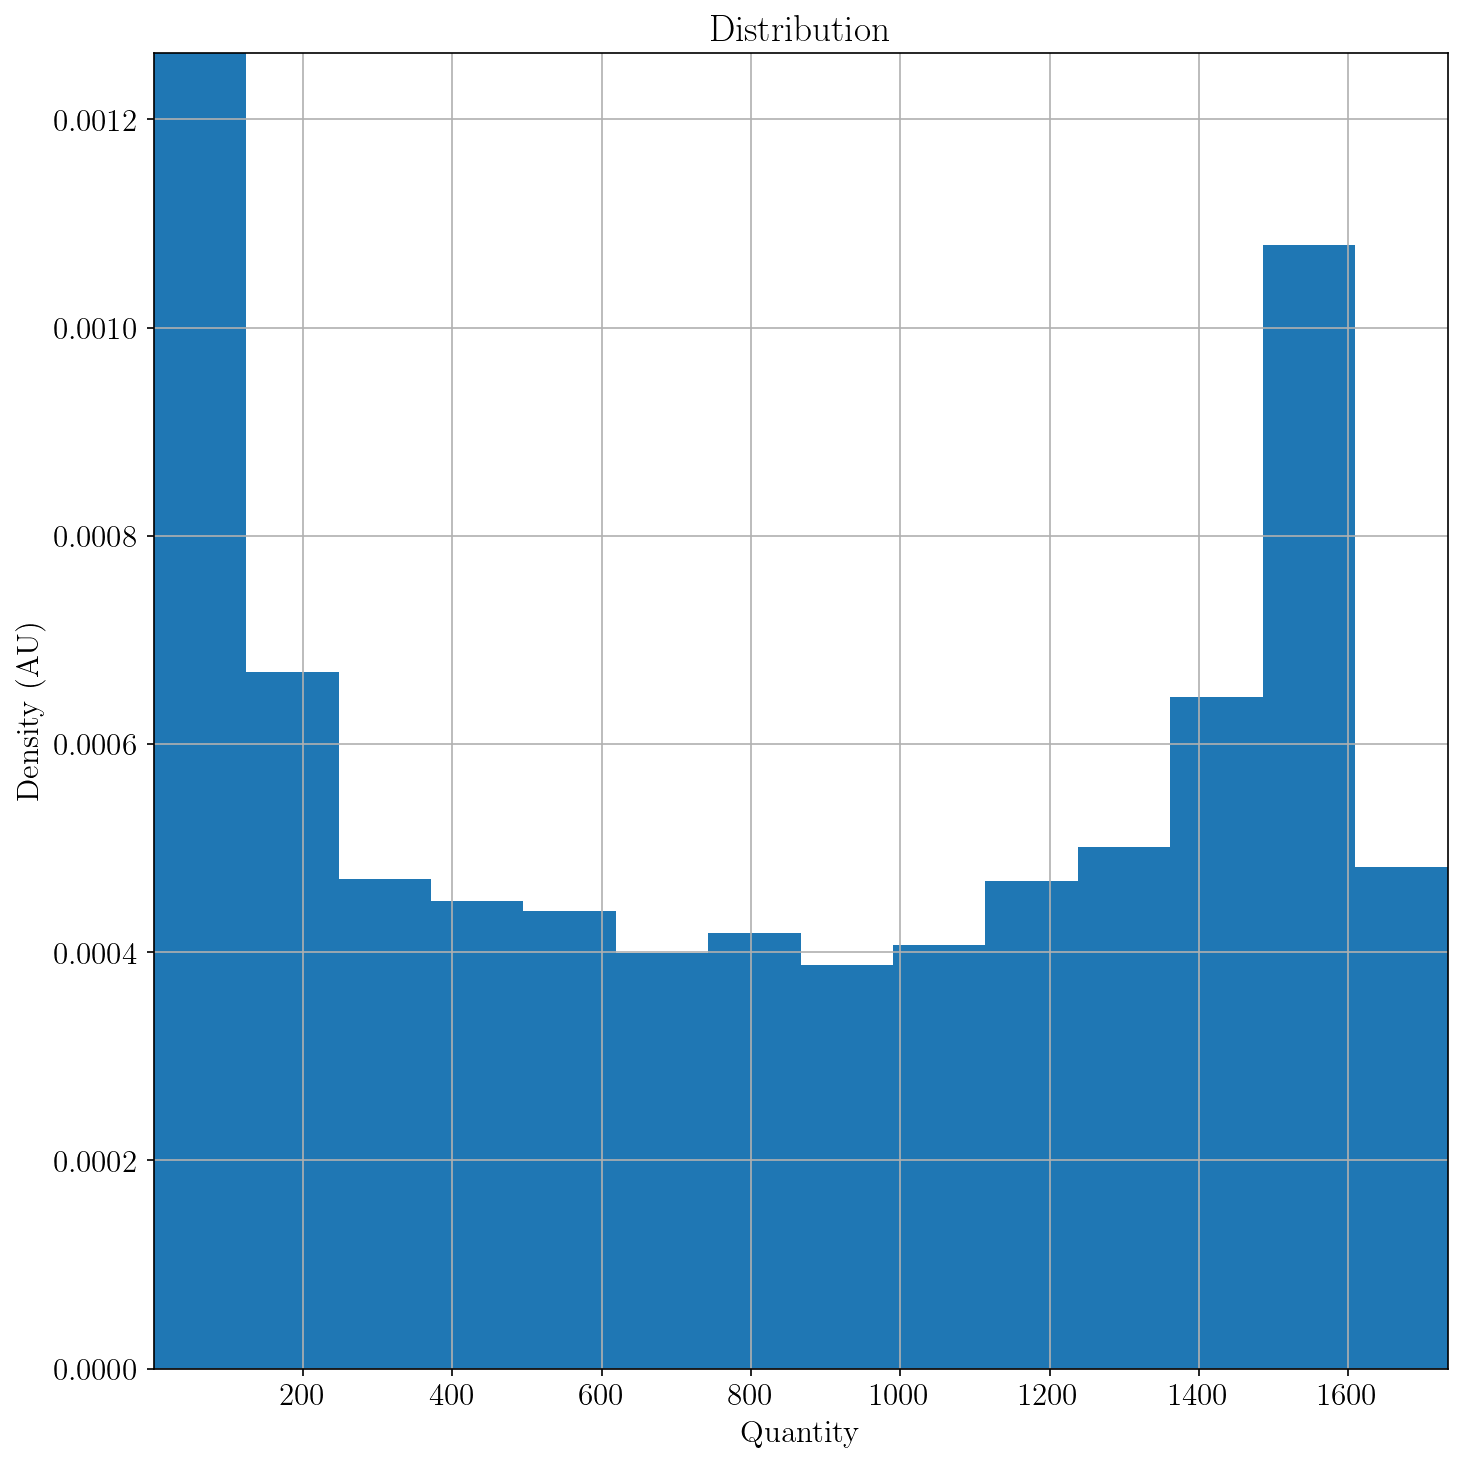

In [10]:
from plot import *

format_plots()
plot_distribution(a.moment(), 1000)